<a href="https://colab.research.google.com/github/Kyrylo-Bakumenko/Blind_Rubiks_Cube_Solver/blob/main/RubicksCubeProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Import Statements & Mount Drive

# Import statements
import cv2
import numpy as np
from tqdm import tqdm
import pickle
from scipy.optimize import root
from numba import njit
import os
import ipyplot
from matplotlib import rcParams
%matplotlib inline
from os import listdir
from os.path import isfile, join
from google.colab import drive
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import figure

# mount google drive
drive.mount('/content/drive');
%cd /content/drive/My Drive/CubeImages
!ls

# Set global variables
COLOR = True
DIM = (400,400)
CATEGORIES = ['SL_Solid','SL_Mixed','S_Solid','S_Mixed']
# figure(figsize=(12, 12), dpi=20)
rcParams['figure.figsize'] = 11 ,8
PICKLED = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CubeImages
acc_0.pickle  SL_Mixed_G.pickle  SL_Solid.pickle   S_Solid
acc_1.pickle  SL_Mixed.pickle	 S_Mixed	   S_Solid_G.pickle
example.jpg   SL_Solid		 S_Mixed_G.pickle  S_Solid.pickle
SL_Mixed      SL_Solid_G.pickle  S_Mixed.pickle


In [4]:
#@title Process images from drive
if not PICKLED:
  for category in CATEGORIES:
    # add both color and greyscale images
    if COLOR:
      # add color images to list
      globals()[category] = []
      for f in listdir(category):
        img = cv2.imread(f'{category}/{f}')
        resize = cv2.resize(img, DIM, cv2.INTER_AREA)
        globals()[category].append(resize)
      # grey scale added color images into new lists
      globals()[f'{category}_G'] = []
      for img in globals()[category]:
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        globals()[f'{category}_G'].append(grey)
    
    # add only greyscale images
    else:
      # add greyscale images to list
      globals()[f'{category}_G'] = []
      for f in listdir(category):
        img = cv2.imread(f'{category}/{f}')
        resize = cv2.resize(img, DIM, cv2.INTER_AREA)
        grey = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
        globals()[f'{category}_G'].append(grey)

In [5]:
#@title Pickle Images 
if not PICKLED:
  for category in CATEGORIES:
    with open(f'{category}_G.pickle', 'wb') as handle:
        pickle.dump(globals()[f'{category}_G'], handle)
    if COLOR:
      with open(f'{category}.pickle', 'wb') as handle:
          pickle.dump(globals()[category], handle)
  PICKLED = True

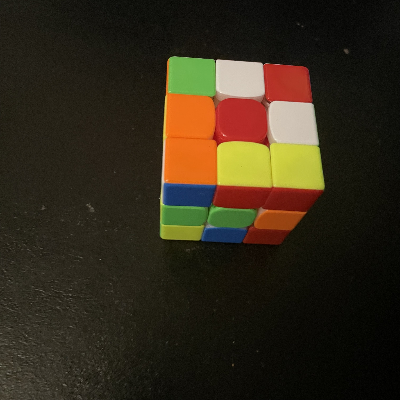

In [6]:
#@title Select Target Image

SL_Mixed = pickle.load(open('SL_Mixed.pickle', 'rb'))
img = SL_Mixed[np.random.randint(0, len(SL_Mixed))]
cv2_imshow(img)

In [7]:
#@title Edge Processing with Canny's Algorithm

def show_edges(img, abstract=True):
  # Apply Gaussian blur to de-noise the image
  blur = cv2.GaussianBlur(img, (5,5), 1)

  # Apply bilateral filter to sharpen edges
  filtered = cv2.bilateralFilter(blur, 5, 50, 50)

  # Apply Canny Edge Detection algorithm to reveal edges
  if abstract:
    canny_f = cv2.Canny(filtered, 50, 150)
  else:
    canny_f = cv2.Canny(filtered, 20, 50)

  # Return edge map
  return canny_f


In [8]:
 #@title Hough Tranform

# equation for line -> x*sin(theta) - y*cos(theta) + r = 0
# 0 <= theta <= 2pi
# r distance from origin

### Custom Hough Tranform ###
# define function - precision 0
@njit
def fun(rho, theta, x, y):
  # args -> [rho, theta]
  return round(x*np.sin(theta)-y*np.cos(theta)+rho, 0)

## accumulater array definition --> rho-theta space ##
def parameter_space_accumulator(DIM):
  # scale rho~array
  max_rho = int(np.ceil(np.sqrt(2*DIM[0]*DIM[0])))
  # scale centiPi~array
  max_theta = int(round(2*np.pi, 2)*100)
  # return array
  return np.zeros((max_rho, max_theta))

# rescale accumulator
@njit
def rescale_to_255(acc):
  max = np.max(acc)
  for rho in range(len(acc)):
    for theta in range(len(acc[0])):
      if acc[rho][theta]==0: continue
      acc[rho][theta] = acc[rho][theta]*255/max
  return acc

## compute transform ##
@njit
def Hough_Transform(edge_map, acc):
  # loop through every pixel
  for x in range(len(edge_map)):
    # # print pretty progress
    # if (x+1) % 50 == 0: cv2_imshow(acc)
    for y in range(len(edge_map[0])):
      if edge_map[x][y]==0: continue
      # update accumulator - precision 0
      for rho in range(len(acc)):
        for theta in range(len(acc[0])):
          epsilon = fun(rho, theta/100, x, y)
          if epsilon != 0: continue
          acc[rho][theta]+=1
  return rescale_to_255(acc)

In [9]:
#@title Non-Maximum Supression Algorithm

@njit
def NMS_singular(acc, window=(10,10)):
  offset_x = window[0]//2
  offset_y = window[1]//2
  # print(offset_x, offset_y)
  for x in range(len(acc)):
    for y in range(len(acc[0])):
      max_val = 0
      x_min = max(x-offset_x, 0)
      x_max = min(x+offset_x+1, len(acc))
      y_min = max(y-offset_y, 0)
      y_max = min(y+offset_y+1, len(acc[0]))
      for xi in range(x_min, x_max):
        for yi in range(y_min, y_max):
          if xi !=x or yi != y: max_val = max(max_val, acc[xi][yi])
      if acc[x][y] < max_val: acc[x][y] = acc[x][y]//2
  return acc

@njit
def NMS_compound(acc, window=(10,10)):
  for w in range(10, window[0], 10):
    if w <= window[1]:
      acc = NMS_singular(acc, (w,w))
    else: break
  return acc

@njit
def count_greater_threshold(acc, thr):
  count=0
  for i in range(len(acc)):
    for ii in range(len(acc[0])):
      if acc[i][ii] > thr: count+=1
  return count

@njit
def reduce_to_count(acc, lines):
  thr = 100
  count = count_greater_threshold(acc, thr)
  while thr < 255 and count > lines:
    thr+=5
    count = count_greater_threshold(acc, thr)
  for i in range(len(acc)):
    for ii in range(len(acc[0])):
      if acc[i][ii] <= thr: acc[i][ii]=0
  return acc

@njit
def NMS(acc, window=(10,10), lines=10):
  acc = NMS_compound(acc, window)
  acc = reduce_to_count(acc, lines)
  return acc

In [10]:
#@title Appending NMS Results to Original Image

def mark_img_by_sol(img, sol):
  for x in range(len(img)):
    for y in range(len(img[0])):
      # if x, y is a solution to rho, theta
      if np.abs(fun(sol[0], sol[1], x, y))<3:
        # set pixel to red
        img[x][y][0] = 255
        img[x][y][1] = 0
        img[x][y][2] = 0
  return img

def mark_img_by_sols(img, sols):
  for sol in sols:
    img = mark_img_by_sol(img, sol)
  return img

def apply_nms_to_image(img, nms):
  sols = []
  for rho in range(len(nms)):
    for theta in range(len(nms[0])):
      if nms[rho][theta] != 0: sols.append([rho, theta])
  return mark_img_by_sols(img, sols)

In [11]:
## create edge map ##
edge_map = show_edges(img);

# create accumulator array
acc = parameter_space_accumulator(DIM)

# Hough Transform 
HT = Hough_Transform(edge_map, acc)

# where things appear to go wrong
# <----------------------------------
# # non-mamximum suppresion
# nms = NMS(np.copy(HT), (20, 20), 8)

nms = reduce_to_count(np.copy(HT), 10)
# <-----------------------------------

# mark solutions form nms in the original image
marked_img = apply_nms_to_image(np.copy(img), nms)


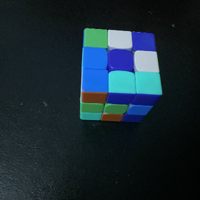
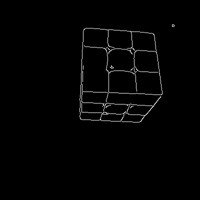
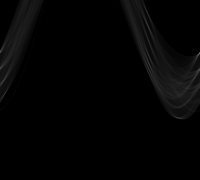


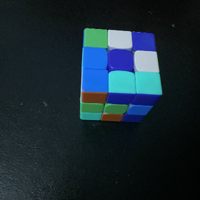
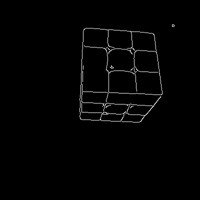
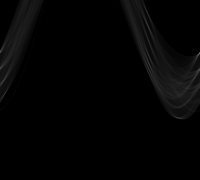

In [14]:
# image list
outputs = np.array([img, edge_map, HT, nms, marked_img], dtype=object)

# show image process as timeline
ipyplot.plot_images(outputs, max_images=3, img_width=200)